In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
selected = sessions[:]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Build response profiles for periods of certain type (BGR, TGT, silence, noise)

In [25]:
iter_count = 100
offset = 0.25
bin_count = 31
event_type = 1  # silence
event_types = ['silence', 'BGR', 'TGT', 'noise']

for session in selected:
    session_data = load_session_data(session)

    tl = session_data['tl']
    trials = session_data['trials']
    cfg = session_data['cfg']
    aeps_events = session_data['aeps_events']
    tgt_matrix = session_data['tgt_matrix']
    single_units = session_data['single_units']
    spike_times = session_data['spike_times']
    unit_names = session_data['unit_names']
    h5_file = session_data['h5_file']

    for unit_name in unit_names:
        profiles = np.zeros([iter_count, bin_count - 1])
        for i in range(iter_count):
            periods = get_idxs_of_event_periods(tl, event_type)

            # split every iteration differently by silence episodes
            split_ratio = 0.66
            train_count = int(len(periods)*split_ratio)
            test_count  = len(periods) - train_count

            all_idxs = np.arange(len(periods))
            train_idxs = np.random.choice(all_idxs, train_count, replace=False)
            test_idxs  = np.array([x for x in all_idxs if not x in train_idxs])
            train_idxs.sort()
            test_idxs.sort()

            # get fake silence pulses
            s_offset  = aeps_events[0][0]
            latency = 0.25
            drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
            p_sil, p_noi, p_bgr, p_tgt = build_silence_and_noise_events(tl, s_offset, latency, drift)

            # shrink pulse times (train part only!!) as if there is no other events
            pulses_all = [p_sil, p_bgr, p_tgt, p_noi]
            pulses = pulses_all[event_type]
            shift = 0
            adjusted_pulses = []
            for period in periods[train_idxs]:
                idxs_tl_l, idxs_tl_r = period[0], period[1]

                idxs = np.where((pulses > tl[idxs_tl_l][0]) & (pulses < tl[idxs_tl_r][0]))[0]
                sel_pulses = pulses[idxs]
                sel_pulses -= tl[idxs_tl_l][0]  # align to time 0
                sel_pulses += shift
                adjusted_pulses.append(sel_pulses)
                shift += tl[idxs_tl_r][0] - tl[idxs_tl_l][0]

            # flatten all pulses
            adjusted_pulses = np.array([item for sublist in adjusted_pulses for item in sublist])
            
            # RANDOM SHIFT / expand
            #adjusted_pulses += RSH
            #adjusted_pulses = adjusted_pulses*4/3  # 3Hz

            strain = get_spike_times_at(tl, spike_times[unit_name], periods[train_idxs])
            strain = np.array([item for sublist in strain for item in sublist])  # flatten to one array
            bins, counts = get_spike_counts(strain, adjusted_pulses, hw=offset, bin_count=bin_count)
            profiles[i] = counts

        # save profiles
        with h5py.File(h5_file, 'a') as f:
            title = 'psth_profiles_%s' % event_types[event_type]
            if title in f['units'][unit_name]:
                del f['units'][unit_name][title]
            f['units'][unit_name].create_dataset(title, data=profiles)

        print(unit_name + '; ', end='')    
    print('Session %s done' % session[-19:-9])

2-10; 2-11; 2-12; 2-13; 2-14; 2-15; 2-16; 2-17; 2-18; 2-19; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; 3-2; 3-3; 4-2; 4-3; 4-4; 4-5; 4-6; 4-7; 5-2; 5-3; 5-4; 6-10; 6-11; 6-12; 6-13; 6-14; 6-15; 6-2; 6-3; 6-4; 6-5; 6-6; 6-7; 6-8; 6-9; Session 2023-02-24 done
2-10; 2-11; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; 4-2; 4-3; 4-4; 4-5; 4-6; 5-2; 5-3; 6-10; 6-11; 6-12; 6-2; 6-3; 6-4; 6-5; 6-6; 6-7; 6-8; 6-9; Session 2023-02-24 done
2-2; 2-3; 4-2; 4-3; 4-4; 4-5; 5-2; 5-3; 5-4; 5-5; 5-6; Session 2023-02-27 done
1-2; 1-3; 4-10; 4-11; 4-12; 4-13; 4-14; 4-2; 4-3; 4-4; 4-5; 4-6; 4-7; 4-8; 4-9; 5-10; 5-11; 5-12; 5-13; 5-2; 5-3; 5-4; 5-5; 5-6; 5-7; 5-8; 5-9; Session 2023-02-27 done
1-2; 1-3; 1-4; 4-2; 4-3; 4-4; 4-5; 4-6; 4-7; 4-8; 5-2; 5-3; 5-4; 5-5; 5-6; 5-7; 5-8; 5-9; Session 2023-02-28 done
1-2; 1-3; 1-4; 1-5; 1-6; 1-7; 2-10; 2-2; 2-3; 2-4; 2-5; 2-6; 2-7; 2-8; 2-9; 4-2; 4-3; 4-4; 4-5; 4-6; 4-7; 4-8; 5-2; 5-3; 5-4; 5-5; 5-6; 5-7; 5-8; Session 2023-02-28 done
1-10; 1-11; 1-12; 1-2; 1-3; 1-4; 1-5; 1-6; 1-

## Plot profiles to check

In [47]:
session = selected[0]
session

'008229_hippoSIT_2022-05-16_20-36-44'

In [48]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
aeps_events = session_data['aeps_events']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']

periods = get_idxs_of_event_periods(tl, 0)

# all silence fake pulses
s_offset, latency = aeps_events[0][0], 0.25
drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
pulses_silence, pulses_noise, _, _ = build_silence_and_noise_events(tl, s_offset, latency, drift)

# pulses for each silence period (list of arrays)
pulses_by_period = get_spike_times_at(tl, pulses_silence, periods, mode='sequence')
adjusted_pulses = np.array([item for sublist in pulses_by_period for item in sublist])  # flatten to one array

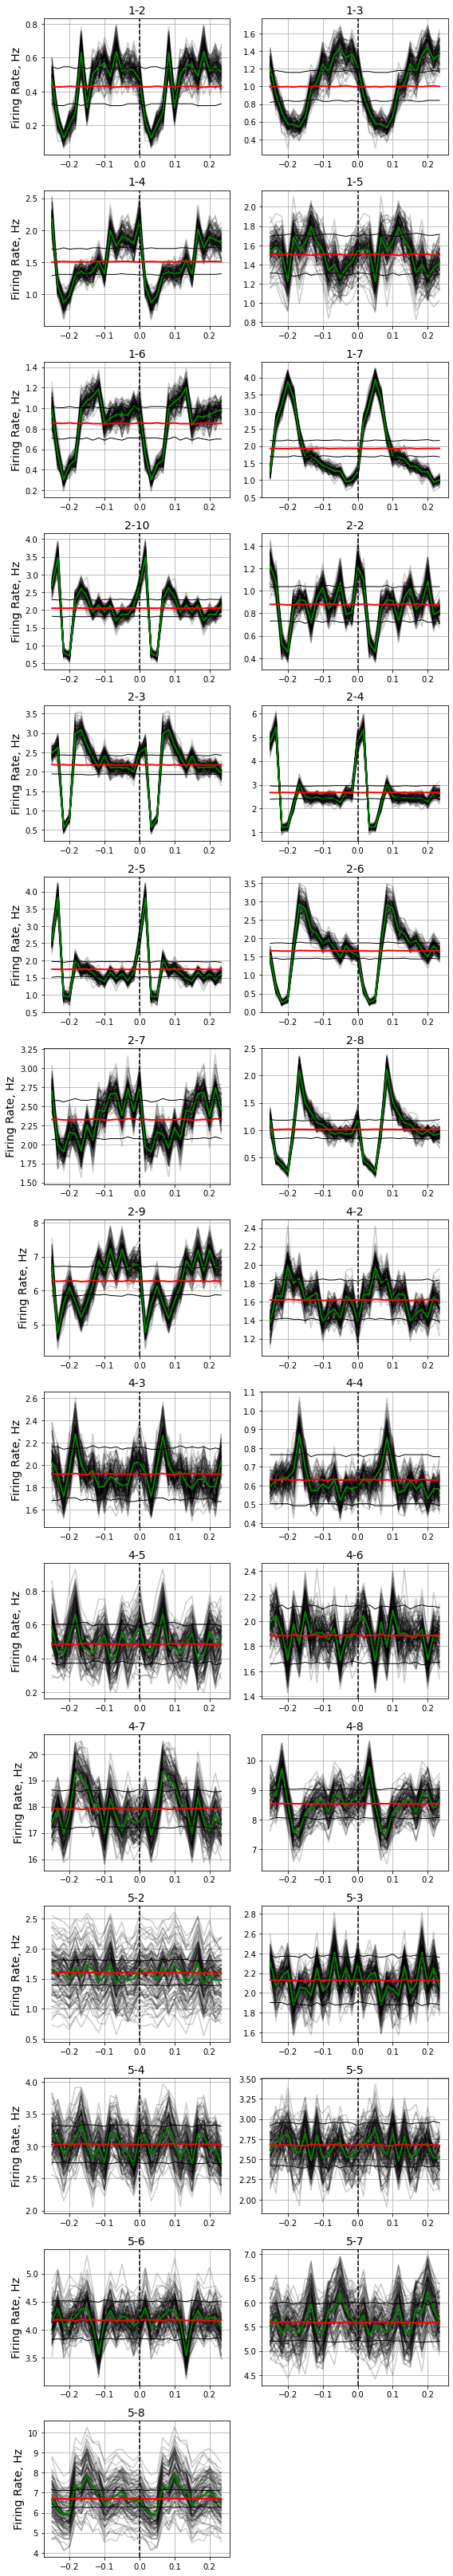

In [30]:
units_to_plot = unit_names[:]
#units_to_plot = ['3-9', '3-2', '3-8', '1-31', '1-21', '1-29', '6-2', '4-3']

cols = 2
rows = int(np.ceil(len(units_to_plot)/cols))
fig  = plt.figure(figsize=(8, rows*3))

for i, unit_name in enumerate(units_to_plot):
    with h5py.File(h5_file, 'r') as f:
        event_name = 'BGR'  # 'silence'
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_%s' % event_name])
        profiles = np.array(f['units'][unit_name]['psth_profiles_%s' % event_name])
    
    ax = fig.add_subplot(rows, cols, i+1)
    for p in profiles:
        ax.plot(shuffled[:, 0], p, alpha=0.2, color='black')
    ax.plot(shuffled[:, 0], profiles.mean(axis=0), lw=2, color='green')
    ax.plot(shuffled[:, 0], shuffled[:, 1], lw=2, color='red')
    ax.plot(shuffled[:, 0], shuffled[:, 3], lw=1, color='black')
    ax.plot(shuffled[:, 0], shuffled[:, 4], lw=1, color='black')
    ax.axvline(0, color='black', ls='--')
    ax.set_title("%s" % unit_name, fontsize=14)
    ax.grid()
    if i % cols == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)
        
fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'profiles_silence_50perc_splits.png'), dpi=500)

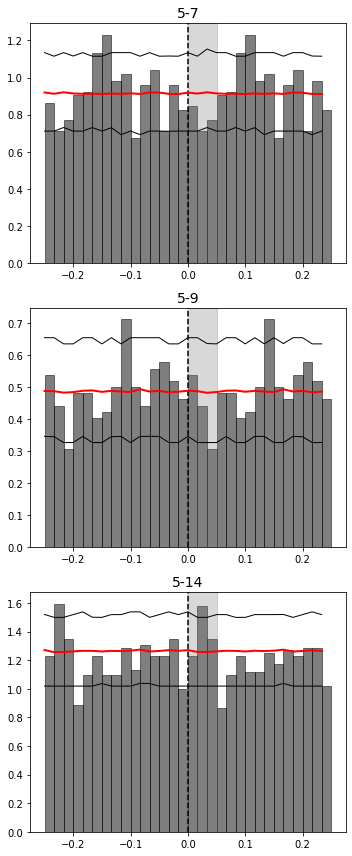

In [53]:
# plot PSTH to check train data
units_to_plot = unit_names[:]
#units_to_plot = ['3-4', '6-3', '6-7']
units_to_plot = ['5-7', '5-9', '5-14']
offset = 0.25
bin_count = 31

cols = 1
rows = int(np.ceil(len(units_to_plot)/cols))
fig = plt.figure(figsize=(5, rows*4))

for i, unit_name in enumerate(units_to_plot):
    strain = get_spike_times_at(tl, spike_times[unit_name], periods)
    strain = np.array([item for sublist in strain for item in sublist])  # flatten to one array
    bins, counts_A = get_spike_counts(strain, adjusted_pulses, hw=offset, bin_count=bin_count)

    # get shuffled
    with h5py.File(h5_file, 'r') as f:
        #shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='black', alpha=0.5, label='All')
    ax.axvline(0, color='black', ls='--')
    ax.set_title("%s" % unit_name, fontsize=14)
    ax.axvspan(0, 0.05, alpha=0.3, color='gray')
    ax.plot(shuffled[:, 0], shuffled[:, 1], lw=2, color='red')
    ax.plot(shuffled[:, 0], shuffled[:, 3], lw=1, color='black')
    ax.plot(shuffled[:, 0], shuffled[:, 4], lw=1, color='black')
    
fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'PPC_sel_silence_ex.png'), dpi=500)